<a href="https://colab.research.google.com/github/sherif17/Hand_Signature_Detection_Verification/blob/main/sieamise_signature_verification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
 bimport os
import cv2
import time
import random
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import preprocess_input
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop

from tensorflow.keras import backend, layers, metrics

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model, Sequential

from tensorflow.keras.utils import plot_model
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import seaborn as sns
import matplotlib.pyplot as pltv

In [ ]:
print(tf.__version__)

2.12.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Reading Dataset**

In [ ]:
# Define the path to the dataset folder
data_dir = '/content/drive/MyDrive/Colab Notebooks/AI-ITI/Computer_vision/Assignment_Two_Verfication/CV_Signature_Dataset'

### **Creating Triplates**

In [ ]:
def read_images(split_type = 'Train'):
    images_dict={}
    image_count = 0
    for person in ['personA','personB','personC','personD','personE']:
        csv_path = f"{data_dir}/{person + '/' + split_type+'/'}{person}_SigVerification{split_type}Labels.csv"
        # print(csv_path)
        df = pd.read_csv(csv_path)
        images_dict[person]={'forged':[],'real':[]}
        for index, row in df.iterrows():
            folder=f'{data_dir}/'+ person + '/' + split_type
            image = row['image_name']
            if os.path.exists(f'{folder}'+f'/{image}'):
                if row['label'] == 'forged':
                    images_dict[person]['forged'].append([folder,image])
                else:
                    images_dict[person]['real'].append([folder,image])
                image_count +=1
    return images_dict , image_count

In [ ]:
def create_triplets(images_dict):
    triplets=[]
    for person in images_dict:
        for i in range(len(images_dict[person]['real'])):
            for j in range(i+1,len(images_dict[person]['real'])):
                anchor = (images_dict[person]['real'][i][0] , images_dict[person]['real'][i][1])
                positive = (images_dict[person]['real'][j][0] , images_dict[person]['real'][j][1])
                k = random.randint(0, len(images_dict[person]['forged'])-1)
                negative = (images_dict[person]['forged'][k][0],images_dict[person]['forged'][k][1])
                triplets.append((anchor,positive,negative))
    random.shuffle(triplets)
    return triplets

In [ ]:
def get_batch(triplet_list, batch_size=256, preprocess=True):
    batch_steps = len(triplet_list)//batch_size
    
    for i in range(batch_steps+1):
        anchor   = []
        positive = []
        negative = []
        
        j = i*batch_size
        while j<(i+1)*batch_size and j<len(triplet_list):
            a, p, n = triplet_list[j]
            a = cv2.imread(f"{a[0]}/{a[1]}")
            p = cv2.imread(f"{p[0]}/{p[1]}")
            n= cv2.imread(f"{n[0]}/{n[1]}")
            a = cv2.resize(a, (128, 128))
            p = cv2.resize(p, (128, 128))
            n = cv2.resize(n, (128, 128))
            anchor.append(a)
            positive.append(p)
            negative.append(n)
            j+=1
        anchor = np.array(anchor)
        positive = np.array(positive)
        negative = np.array(negative)
        
        if preprocess:
            anchor = preprocess_input(anchor)
            positive = preprocess_input(positive)
            negative = preprocess_input(negative)
        
        yield ([anchor, positive, negative])

In [ ]:
train_images_dict,train_image_count = read_images('Train')
test_images_dict,test_image_count = read_images('Test')
train_triplets = create_triplets(train_images_dict)
test_triplets = create_triplets(test_images_dict)

/content/drive/MyDrive/Colab Notebooks/AI-ITI/Computer_vision/Assignment_Two_Verfication/CV_Signature_Dataset/personA/Train/personA_SigVerificationTrainLabels.csv
/content/drive/MyDrive/Colab Notebooks/AI-ITI/Computer_vision/Assignment_Two_Verfication/CV_Signature_Dataset/personB/Train/personB_SigVerificationTrainLabels.csv
/content/drive/MyDrive/Colab Notebooks/AI-ITI/Computer_vision/Assignment_Two_Verfication/CV_Signature_Dataset/personC/Train/personC_SigVerificationTrainLabels.csv
/content/drive/MyDrive/Colab Notebooks/AI-ITI/Computer_vision/Assignment_Two_Verfication/CV_Signature_Dataset/personD/Train/personD_SigVerificationTrainLabels.csv
/content/drive/MyDrive/Colab Notebooks/AI-ITI/Computer_vision/Assignment_Two_Verfication/CV_Signature_Dataset/personE/Train/personE_SigVerificationTrainLabels.csv
/content/drive/MyDrive/Colab Notebooks/AI-ITI/Computer_vision/Assignment_Two_Verfication/CV_Signature_Dataset/personA/Test/personA_SigVerificationTestLabels.csv
/content/drive/MyDrive/C

### **Visualization**

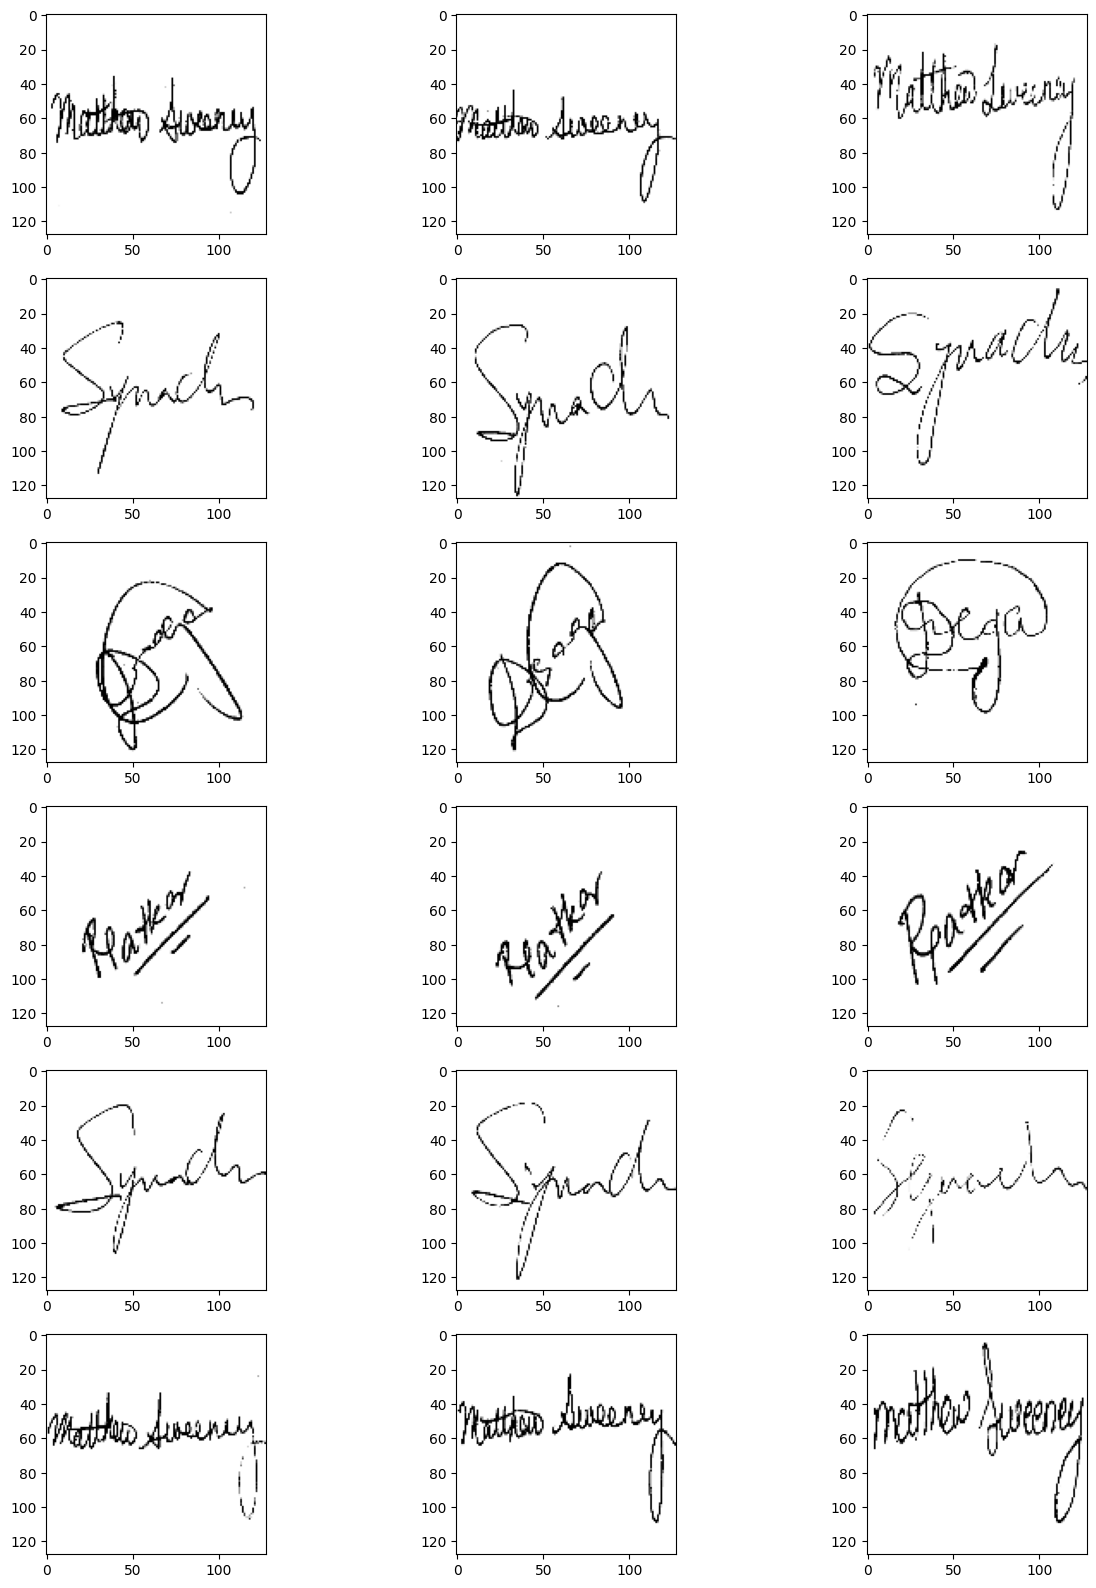

In [ ]:
num_plots = 6

f, axes = plt.subplots(num_plots, 3, figsize=(15, 20))

for x in get_batch(train_triplets, batch_size=num_plots, preprocess=False):
    a,p,n = x
    for i in range(num_plots):
        axes[i, 0].imshow(a[i])
        axes[i, 1].imshow(p[i])
        axes[i, 2].imshow(n[i])
        i+=1
    break

In [ ]:
def get_encoder(input_shape):
    """ Returns the image encoding model """

    pretrained_model = Xception(
        input_shape=input_shape,
        weights='imagenet',
        include_top=False,
        pooling='avg',
    )
    
    for i in range(len(pretrained_model.layers)-27):
        pretrained_model.layers[i].trainable = False

    encode_model = Sequential([
        pretrained_model,
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(256, activation="relu"),
        layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))
    ], name="Encode_Model")
    return encode_model

In [ ]:
class DistanceLayer(layers.Layer):
    # A layer to compute ‖f(A) - f(P)‖² and ‖f(A) - f(N)‖²
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)
    

def get_siamese_network(input_shape = (128, 128, 3)):
    encoder = get_encoder(input_shape)
    
    # Input Layers for the images
    anchor_input   = layers.Input(input_shape, name="Anchor_Input")
    positive_input = layers.Input(input_shape, name="Positive_Input")
    negative_input = layers.Input(input_shape, name="Negative_Input")
    
    ## Generate the encodings (feature vectors) for the images
    encoded_a = encoder(anchor_input)
    encoded_p = encoder(positive_input)
    encoded_n = encoder(negative_input)
    
    # A layer to compute ‖f(A) - f(P)‖² and ‖f(A) - f(N)‖²
    distances = DistanceLayer()(
        encoder(anchor_input),
        encoder(positive_input),
        encoder(negative_input)
    )
    
    # Creating the Model
    siamese_network = Model(
        inputs  = [anchor_input, positive_input, negative_input],
        outputs = distances,
        name = "Siamese_Network"
    )
    return siamese_network

siamese_network = get_siamese_network()
siamese_network.summary()

83683744/83683744 [==============================] - 1s 0us/step
Model: "Siamese_Network"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Anchor_Input (InputLayer)      [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Positive_Input (InputLayer)    [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Negative_Input (InputLayer)    [(None, 128, 128, 3  0           []                               
                   

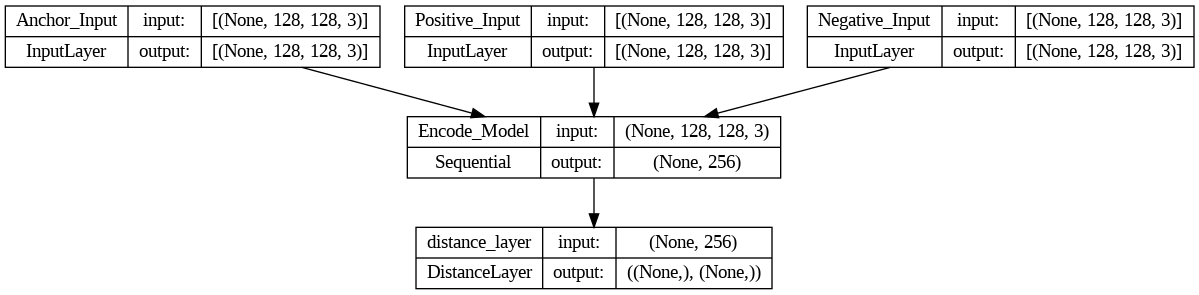

In [ ]:
plot_model(siamese_network, show_shapes=True, show_layer_names=True)

In [ ]:
class SiameseModel(Model):
    # Builds a Siamese model based on a base-model
    def __init__(self, siamese_network, margin=1.0):
        super(SiameseModel, self).__init__()
        
        self.margin = margin
        self.siamese_network = siamese_network
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape get the gradients when we compute loss, and uses them to update the weights
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)
            
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.siamese_network.trainable_weights))
        
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)
        
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # Get the two distances from the network, then compute the triplet loss
        ap_distance, an_distance = self.siamese_network(data)
        loss = tf.maximum(ap_distance - an_distance + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics so the reset_states() can be called automatically.
        return [self.loss_tracker]

In [ ]:
siamese_model = SiameseModel(siamese_network)
optimizer = Adam(learning_rate=1e-3, epsilon=1e-01)
siamese_model.compile(optimizer=optimizer)

In [ ]:
def test_on_triplets(batch_size = 256):
    pos_scores, neg_scores = [], []

    for data in get_batch(test_triplets, batch_size=batch_size):
        prediction = siamese_model.predict(data)
        pos_scores += list(prediction[0])
        neg_scores += list(prediction[1])
    
    accuracy = np.sum(np.array(pos_scores) < np.array(neg_scores)) / len(pos_scores)
    ap_mean = np.mean(pos_scores)
    an_mean = np.mean(neg_scores)
    ap_stds = np.std(pos_scores)
    an_stds = np.std(neg_scores)
    
    print(f"Accuracy on test = {accuracy:.5f}")
    return (accuracy, ap_mean, an_mean, ap_stds, an_stds)

### **Training**

In [ ]:
save_all = False
epochs = 5
batch_size = 128

max_acc = 0
train_loss = []
test_metrics = []

for epoch in range(1, epochs+1):
    t = time.time()
    
    # Training the model on train data
    epoch_loss = []
    for data in get_batch(train_triplets, batch_size=batch_size):
        loss = siamese_model.train_on_batch(data)
        epoch_loss.append(loss)
    epoch_loss = sum(epoch_loss)/len(epoch_loss)
    train_loss.append(epoch_loss)

    print(f"\nEPOCH: {epoch} \t (Epoch done in {int(time.time()-t)} sec)")
    print(f"Loss on train    = {epoch_loss:.5f}")
    
    # Testing the model on test data
    metric = test_on_triplets(batch_size=batch_size)
    test_metrics.append(metric)
    accuracy = metric[0]
    
    # Saving the model weights
    if save_all or accuracy>=max_acc:
        siamese_model.save_weights("siamese_model")
        max_acc = accuracy

# Saving the model after all epochs run
siamese_model.save_weights("siamese_model-final")


EPOCH: 1 	 (Epoch done in 248 sec)
Loss on train    = 0.00028
1/1 [==============================] - 4s 4s/step
Accuracy on test = 0.93333

EPOCH: 2 	 (Epoch done in 247 sec)
Loss on train    = 0.00000
1/1 [==============================] - 4s 4s/step
Accuracy on test = 0.93333

EPOCH: 3 	 (Epoch done in 248 sec)
Loss on train    = 0.00000
1/1 [==============================] - 3s 3s/step
Accuracy on test = 0.93333

EPOCH: 4 	 (Epoch done in 240 sec)
Loss on train    = 0.00000
1/1 [==============================] - 4s 4s/step
Accuracy on test = 0.93333

EPOCH: 5 	 (Epoch done in 238 sec)
Loss on train    = 0.00000
1/1 [==============================] - 4s 4s/step
Accuracy on test = 0.93333


In [ ]:
def extract_encoder(model):
    encoder = get_encoder((128, 128, 3))
    i=0
    for e_layer in model.layers[0].layers[3].layers:
        layer_weight = e_layer.get_weights()
        encoder.layers[i].set_weights(layer_weight)
        i+=1
    return encoder

encoder = extract_encoder(siamese_model)
encoder.save_weights("encoder")
encoder.summary()

Model: "Encode_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               1049088   
                                                                 
 batch_normalization_9 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dense_3 (Dense)             (None, 256)               131328    
                                                                 
 lambda_1 (Lambda)           (None, 256)               0         
                                                      

### **Testing**

In [ ]:
def classify_images(face_list1, face_list2, threshold=1.3):
    # Getting the encodings for the passed faces
    tensor1 = encoder.predict(face_list1)
    tensor2 = encoder.predict(face_list2)
    
    distance = np.sum(np.square(tensor1-tensor2), axis=-1)
    prediction = np.where(distance<=threshold, 0, 1)
    return prediction

1/1 [==============================] - 1s 1s/step

Accuracy of model: 0.9



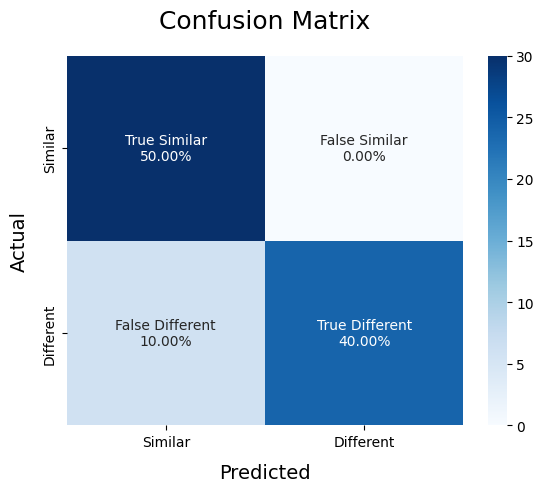

In [ ]:
def ModelMetrics(pos_list, neg_list):
    true = np.array([0]*len(pos_list)+[1]*len(neg_list))
    pred = np.append(pos_list, neg_list)
    
    # Compute and print the accuracy
    print(f"\nAccuracy of model: {accuracy_score(true, pred)}\n")
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(true, pred)

    categories  = ['Similar','Different']
    names = ['True Similar','False Similar', 'False Different','True Different']
    percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(names, percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)


pos_list = np.array([])
neg_list = np.array([])

for data in get_batch(test_triplets, batch_size=256):
    a, p, n = data
    pos_list = np.append(pos_list, classify_images(a, p))
    neg_list = np.append(neg_list, classify_images(a, n))
    break

ModelMetrics(pos_list, neg_list)